<a href="INSERT_colab_R_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

label: exercise
# Exercise
Write your own stochastic subgradient descent routine to solve the soft-margin SVM in the primal formulation.

Hints:

- Use the regularized-empirical-risk-minimization formulation, i.e., an optimization criterion without constraints.
- No kernels, just a linear SVM.
- Compare your implementation with an existing implementation (e.g., `kernlab` in R or `sklearn.svm.SVC` in Pythong). Are your results similar? Note that you might have to switch off the automatic data scaling in the already existing implementation.


label: import_and_globals
## Imports and global variables

In [ ]:
#| label: import_and_globals

# You may need to first run:
# install.packages(c("mlbench", "kernlab"))

library(mlbench)
library(kernlab)

# SVM regularization parameter (inverse of lambda)
C = 1

set.seed(2L) #  for reproducibility

Warning message:
"package 'mlbench' was built under R version 4.4.3"


label: algorithm_explanation

# PEGASOS Algorithm Explanation

The PEGASOS algorithm is a stochastic gradient descent method for training linear SVMs. It works by:

1. **Random Sampling**: At each iteration, randomly select one training example
2. **Weight Decay**: Apply regularization by shrinking the weight vector: `θ ← (1 - λα)θ`
3. **Margin Check**: If the selected example is within the margin (i.e., `y_i * f(x_i) < 1`), update the weights: `θ ← θ + α * y_i * x_i`
4. **Repeat**: Continue until convergence or maximum iterations

More details can be found in the [i2ml chapter on linear SVMs](https://slds-lmu.github.io/i2ml/chapters/16_linear_svm/16-05-optimization)


In [1]:
#| label: pegasos_implementation

#' PEGASOS Algorithm for Linear SVM
#' 
#' This function implements the PEGASOS (Primal Estimated sub-GrAdient SOlver for SVM) 
#' algorithm, which is a stochastic gradient descent method for training linear SVMs.
#' 
#' For more details, see https://slds-lmu.github.io/i2ml/chapters/16_linear_svm/16-05-optimization
#'
#' @param y outcome vector (should be -1 or +1)
#' @param X design matrix (including a column of 1s for the intercept)
#' @param nr_iter number of iterations for the algorithm
#' @param theta starting values for thetas
#' @param lambda penalty parameter (regularization strength)
#' @param alpha step size for weight decay
#' @return theta vector containing the learned parameters

pegasos_linear <- function(
    y, 
    X, 
    nr_iter = 50000, 
    theta = rnorm(ncol(X)), 
    lambda = 1, 
    alpha = 0.01)
{
    t = 1
    n = NROW(y)
    
    while(t <= nr_iter){
        f_current = X %*% theta
        i = sample(1:n, 1)  # randomly sample one training example
        
        # Weight decay step
        theta <- (1 - lambda * alpha) * theta
        
        # Add gradient step if the example is within the margin
        if(y[i] * f_current[i] < 1) {
            theta <- theta + alpha * y[i] * X[i,]
        }
        t = t + 1
    }
    return(theta)
}

label: data_setup

## Data Generation and Setup

For R we'll use the `mlbench.twonorm` dataset, which generates a two-class problem with two features. This is a classic benchmark dataset for binary classification.

For Python, we can use `sklearn.datasets.make_classification` to generate a similar dataset.

In [3]:
#| label: data_generation
# 2-class normal distribution data
data = mlbench.twonorm(n = 100, d = 2)
data = as.data.frame(data)

# Extract features and target
X = as.matrix(data[, 1:2])
y = data$classes

# Display the data structure
cat("Data dimensions:", dim(data), "\n")
cat("Feature matrix X dimensions:", dim(X), "\n")
cat("Classes:", unique(y)) # we will need to convert them to -1 and +1 later

Data dimensions: 100 3 
Feature matrix X dimensions: 100 2 
Classes: 2 1

label: visual_inspection
# Visual Inspection of the Data

We can see that the data is mostly linearly separable, but there are some points that are close to the decision boundary.

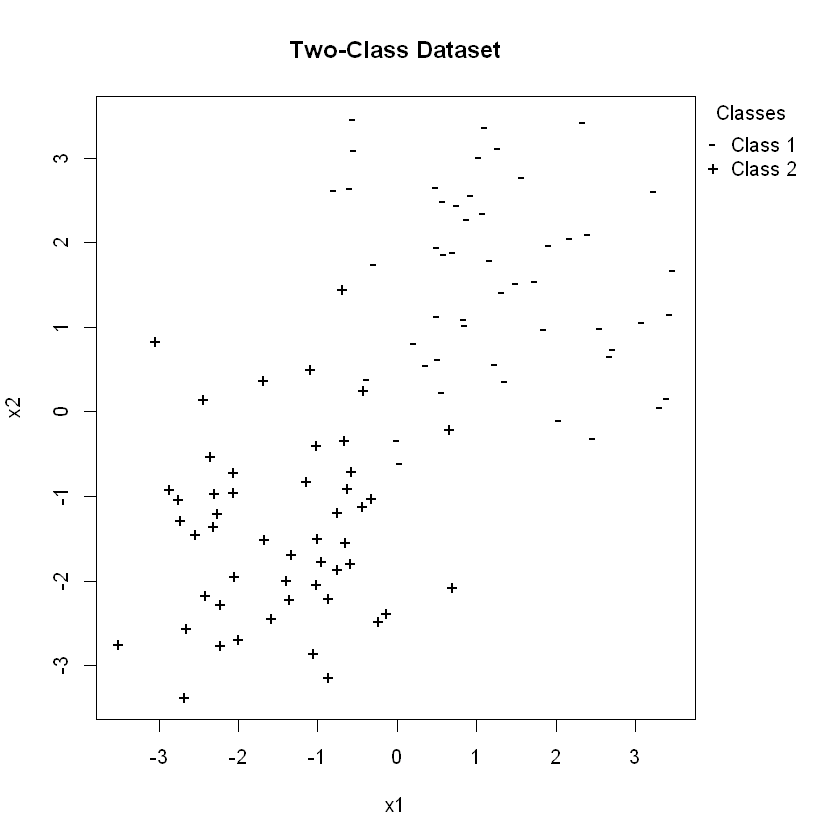

In [4]:
#| label: plot_data

par(mar = c(5, 4, 4, 6))

plot(x = data$x.1, y = data$x.2, 
     pch = ifelse(data$classes == 1, "-", "+"), 
     col = "black",
     xlab = "x1", ylab = "x2",
     main = "Two-Class Dataset")

legend(par('usr')[2], par('usr')[4], 
       bty = 'n', xpd = NA, 
       legend = c("Class 1", "Class 2"), 
       pch = c("-", "+"), 
       title = "Classes")

label: train_pegasos
# Training the PEGASOS Algorithm

In [5]:
#| label: train_pegasos

# Recode target variable: class "2" becomes +1, class "1" becomes -1
y = ifelse(y == "2", 1, -1)

# Train PEGASOS model
# Note: lambda = 1/(C*n) where C is the SVM regularization parameter
model_pegasos = pegasos_linear(y, cbind(1, X), lambda = 1/(C * NROW(y)))

cat("PEGASOS model parameters:\n")
cat("Intercept:", model_pegasos[1], "\n")
cat("Coefficients:", model_pegasos[2:3], "\n")

PEGASOS model parameters:
Intercept: -0.05743352 
Coefficients: -1.347267 -0.7917586 


label: decision_boundaries
# Decision Boundaries Visualization

Now we'll use the trained model to visualize the decision boundaries. Additionally, for comparison we will also fit a Logistic Regression model and visualize its decision boundary as well.

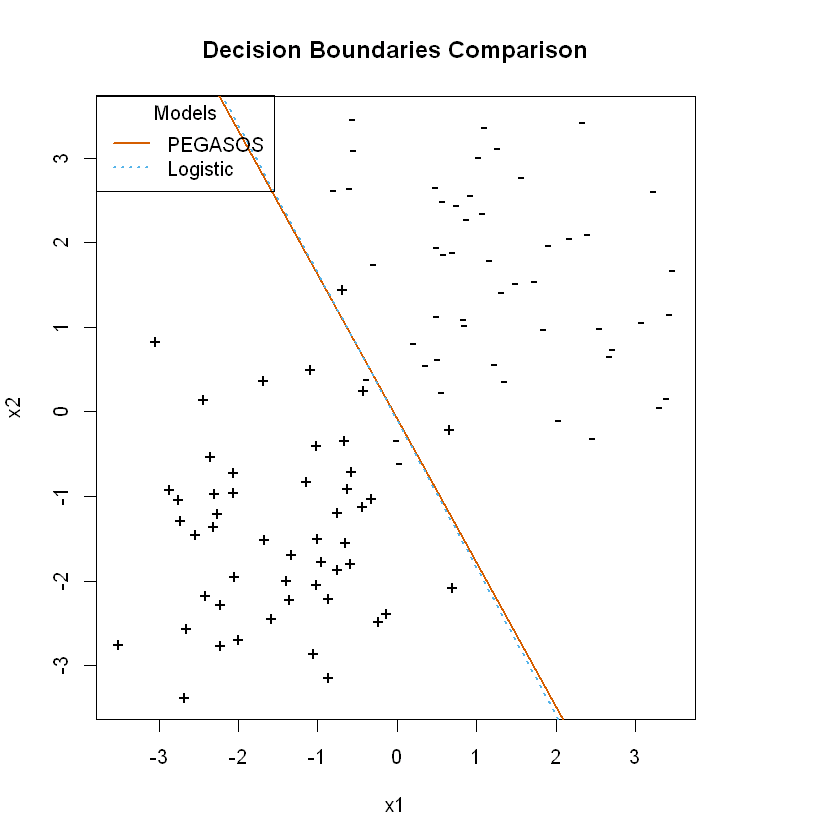

In [ ]:
#| label: plot_boundaries

# Recreate the plot with both classes
par(mar = c(5, 4, 4, 6))
plot(x = data$x.1, y = data$x.2, 
     pch = ifelse(data$classes == 1, "-", "+"), 
     col = "black",
     xlab = "x1", ylab = "x2",
     main = "Decision Boundaries Comparison")

# Add PEGASOS decision boundary
# Decision boundary equation: θ₀ + θ₁x₁ + θ₂x₂ = 0
# Rearranged: x₂ = -(θ₀ + θ₁x₁)/θ₂
abline(a = -model_pegasos[1] / model_pegasos[3], 
       b = -model_pegasos[2] / model_pegasos[3], 
       col = "#D55E00", lwd = 2)

# Compare to logistic regression
model_logreg = glm(classes ~ ., data = data, family = binomial())
abline(a = -coef(model_logreg)[1] / coef(model_logreg)[3], 
       b = -coef(model_logreg)[2] / coef(model_logreg)[3], 
       col = "#0800ffff", lty = 3, lwd = 2)


legend("topleft",
       title  = "Models",
       legend = c("PEGASOS", "Logistic"),
       lty    = c(1, 3),
       lwd    = c(2, 2),
       col    = c("#D55E00", "#0800ffff")
    )

label: evaluation

# Evaluating the PEGASOS Model

We'll compute the accuracy and the confusion matrix. In practice, other metrics should be also considered, e.g. precision, recall, F1-score (threshold dependent); ROC AUC, PR AUC (threshold independent).

In [10]:
#| label: evaluate_pegasos

# Compute decision values (distances from decision boundary)
f_pegasos = cbind(1, X) %*% model_pegasos # we add a column of 1s for the intercept

# Check classification accuracy
# Positive values indicate class +1, negative values indicate class -1
predictions = sign(f_pegasos)
accuracy = sum(predictions == y) / length(y)

cat("PEGASOS Classification Results:\n")
cat("Accuracy:", round(accuracy * 100, 2), "%\n")

# Display confusion matrix (sign of decision values vs true labels)
cat("\nConfusion Matrix (decision sign vs true labels):\n")
print(table(sign(f_pegasos * y)))

PEGASOS Classification Results:
Accuracy: 95 %



Confusion Matrix (decision sign vs true labels):

-1  1 
 5 95 


label: kernellab_or_sklearn
# Using `kernlab` (R) or `sklearn.svm.SVC` (Python) for Comparison

Accuracy is identical

In [ ]:
#| label: train_kernlab_or_sklearn

# Train kernlab SVM with linear kernel
# Note: we cannot expect a PERFECT match due to different optimization approaches
model_kernlab = ksvm(classes ~ ., 
                   data = data, 
                   kernel = "vanilladot",  # linear kernel
                   C = C, 
                   kpar = list(), 
                   scaled = FALSE)

# Get decision values from kernlab
f_kernlab = predict(model_kernlab, newdata = data, type = "decision")

cat("kernlab SVM Classification Results:\n")
kernlab_correct = sum(sign(f_kernlab) == y)
kernlab_accuracy = kernlab_correct / length(y)
cat("Accuracy:", round(kernlab_accuracy * 100, 2), "%\n")

# Display confusion matrix for kernlab
cat("\nkernlab Confusion Matrix:\n")
print(table(sign(f_kernlab * y)))

kernlab SVM Classification Results:
Accuracy: 95 %

kernlab Confusion Matrix:

-1  1 
 5 95 


label: comparison_coefs
## Comparison of Model Coefficients

We can see that both the predictions and coefficients are almost identical.

In [ ]:
#| label: compare_models

# Compare decision values between models
decision_diff = abs(f_kernlab - f_pegasos)
cat("Decision Values Comparison:\n")
cat("Range of absolute differences:", range(decision_diff), "\n")
cat("Mean absolute difference:", mean(decision_diff), "\n")

# Extract and compare model coefficients
# For kernlab: coefficients are computed from support vectors
kernlab_params = c(
  -model_kernlab@b,  # intercept (note: kernlab uses negative offset)
  colSums(X[model_kernlab@SVindex, ] * 
          model_kernlab@alpha[[1]] * 
          y[model_kernlab@SVindex])  # weighted sum of support vectors
)

# Combine parameters for comparison
all_params = rbind(
  PEGASOS = model_pegasos,
  kernlab = kernlab_params
)

cat("\nModel Parameters Comparison:\n")
colnames(all_params) = c("Intercept", "Coeff_x1", "Coeff_x2")
print(all_params)

cat("\nParameter differences:\n")
param_diff = abs(all_params[1,] - all_params[2,])
print(param_diff)

Decision Values Comparison:
Range of absolute differences: 0.00014996 0.3804974 
Mean absolute difference: 0.1469776 

Model Parameters Comparison:
          Intercept  Coeff_x1   Coeff_x2
PEGASOS -0.05743352 -1.347267 -0.7917586
kernlab -0.09763532 -1.263707 -0.7747026

Parameter differences:
 Intercept   Coeff_x1   Coeff_x2 
0.04020180 0.08356038 0.01705603 


label: emp_risk_comparions
## Comparison of empirical risks

In [ ]:
#| label: calculate_risk

# Define empirical risk function for SVM
# Risk = 0.5 * ||w||² + C * Σ max(0, 1 - y_i * f(x_i))
emp_risk <- function(theta) {
    f = cbind(1, X) %*% theta
    return(0.5 * sum(theta[2:3]^2) + C*sum(ifelse(f > 0, f, 0)))
}

# Calculate empirical risk for both models
risks = apply(all_params, 1, emp_risk)
cat("Empirical Risk Comparison:\n")
cat("PEGASOS risk:", round(risks[1], 4), "\n")
cat("kernlab risk:", round(risks[2], 4), "\n")

risk_difference_abs = round(abs(risks[1] - risks[2]), 4)
cat("Risk difference:", risk_difference_abs, "\n")

Empirical Risk Comparison:
PEGASOS risk: 153.3287 
kernlab risk: 143.8169 
Risk difference: 9.5118 


label: plotting_everything
# Plotting

In [31]:
#| label: plot_margins_prep

# Use kernlab parameters for margin visualization
params_kernlab = all_params[2,]  # kernlab parameters

# Calculate margin width
# Margin = 1 / ||w|| where w are the feature coefficients (excluding intercept)
margin = 1 / sqrt(sum(params_kernlab[2:3]^2))

# Calculate margin boundaries
# The margin lines are parallel to the decision boundary
m = -params_kernlab[2] / params_kernlab[3] # Slope of decision boundary

# Transform margin width to intercept shift
# (margin shift is orthogonal to decision boundary)
t_0 = margin / (cos(atan(m)))

# Find support vectors on decision boundary
# Support vectors have decision values close to ±1
sv_tolerance = 0.02  # tolerance for identifying support vectors on boundary
nv_sv_idx = abs(abs(f_kernlab[model_kernlab@SVindex]) - 1) < sv_tolerance


cat("Support Vector Information:\n")
cat("Total support vectors:", length(model_kernlab@SVindex), "\n")
cat("Support vectors on margin:", sum(nv_sv_idx), "\n")
cat("Margin width:", round(margin, 3), "\n")

Support Vector Information:
Total support vectors: 12 
Support vectors on margin: 4 
Margin width: 0.675 


label: complete_visualization
## Complete visualization

- We can see that all the models produce almost identical decision boundary
- The margins are plotted for the `kernlab`'s (R) / `sklearn.svm.SVC` (Python) model

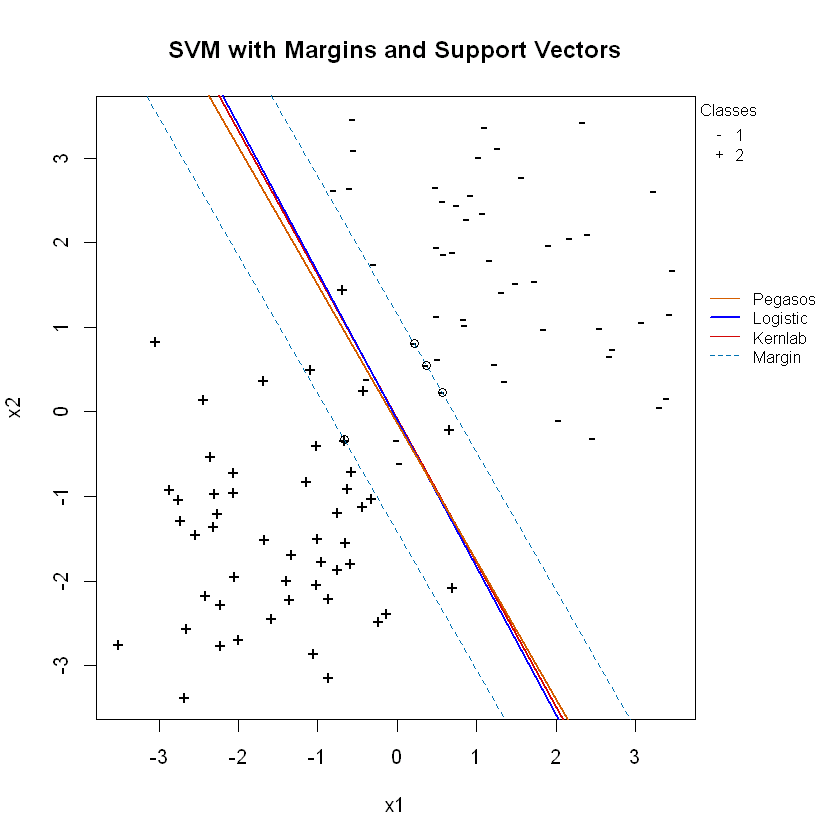

In [32]:
#| label: complete visualization

par(mar = c(5, 4, 4, 6))
plot(x = data$x.1, y = data$x.2, 
     pch = ifelse(data$classes == 1, "-", "+"), 
     col = "black",
     xlab = "x1", ylab = "x2",
     main = "SVM with Margins and Support Vectors")

# PEGASOS decision boundary
abline(a = -model_pegasos[1] / model_pegasos[3], 
       b = -model_pegasos[2] / model_pegasos[3], 
       col = "#d40808ff", lwd = 2)

# Logistic regression boundary
abline(a = -coef(model_logreg)[1] / coef(model_logreg)[3], 
       b = -coef(model_logreg)[2] / coef(model_logreg)[3], 
       col = "#0800ffff", lwd = 2)

# kernlab decision boundary
abline(a = -params_kernlab[1] / params_kernlab[3], 
       b = m,
       col = "#D55E00", lwd = 2)

# Add margin boundaries
abline(a = -params_kernlab[1] / params_kernlab[3] + t_0, 
       b = m, 
       col = "#0072B2", lty = 2)
abline(a = -params_kernlab[1] / params_kernlab[3] - t_0, 
       b = m, 
       col = "#0072B2", lty = 2)


points(X[model_kernlab@SVindex[nv_sv_idx],])


legend(par('usr')[2], par('usr')[4], , bty='n', xpd=NA, legend=c("1","2"), 
       pch=c("-","+"), title="Classes", cex = 0.8)
legend(par('usr')[2], 1.8, , bty='n', xpd=NA, 
       legend=c("Pegasos","Logistic","Kernlab","Margin"), 
       lty=c(1,1,1,2), 
       col = c("#D55E00","#0800ffff","#d40808ff","#0072B2"), 
       title="", cex = 0.8, lwd = c(1,2,1,1))